### Binary Logistic Regression (dim = 2)

N = 1000

N_train = 100

N_test = 100

polynomials_max_deg = 3

$f(\theta) = \theta_1 + \theta_2 $

$\tilde{n} = 2,10,100,\infty$

$K=2$

In [1]:
import numpy as np
import scipy 
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.misc import comb
from matplotlib import pyplot as plt
from scipy.special import hermitenorm
from tqdm import tqdm
from numpy.polynomial.hermite_e import HermiteE
import matplotlib.mlab as mlab
%matplotlib inline
from joblib import Parallel, delayed
from scipy.optimize import minimize
from itertools import product
import sys
import warnings
from sklearn import linear_model
import math
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from numpy.random import normal  
import timeit

## BLR data generation

In [2]:
d = 2
def r(theta, x):
    return np.exp(theta.T @ x)/(1+np.exp(theta.T @ x))
def generate_data(p, n):
    X = np.empty((n,p))
    Y = np.empty(n)
    for i in range(n):
        prob = multivariate_normal.rvs(0,1,p)
        X[i, prob < 0] = -1
        X[i, prob >= 0] = +1
        X[i] = X[i]/np.linalg.norm(X[i])
        Y[i] = bernoulli.rvs(r(np.ones(p),X[i].reshape(p,1)))
    return X,Y.reshape((n,1))

In [3]:
np.random.seed(55)
X_reg, Y_reg = generate_data(2,100)

In [4]:
def sigma(X):
    n = X.shape[0]
    p = X.shape[1]
    S = np.zeros((p,p))
    for i in range(n):
        S = S + X[i].reshape((p,1)) @ X[i].reshape(1,p)
    return S 
    
def f_grad(theta, X, Y, Sigma):
    n = X.shape[0]
    p = X.shape[1]
    lambda_c = 3*p / np.pi**2
    LOG = np.zeros((p,1))
    for i in range(n):
        LOG = LOG + X[i].reshape((p,1)) / (1+np.exp(theta.T @ X[i].reshape((p,1))))
    F = X.T @ Y - LOG + lambda_c * Sigma @ theta
    return F

def MLE(X,Y,Sigma):
    n = X.shape[0]
    p = X.shape[1]
    lambda_c = 3*p / np.pi**2
    eps = 1e-6
    mu = np.max(np.linalg.eigvals(Sigma))
    M = (lambda_c + 0.25*n) * mu
    theta_k =[]
    theta_k.append(np.ones((p,1)))
    theta_k.append(theta_k[0] - 1/(2*M) * f_grad(theta_k[0],X,Y,Sigma))
    i = 2
    while(np.linalg.norm(theta_k[i-1] - theta_k[i-2])**2 > eps**2):
        theta_k.append(theta_k[i-1] - 1/(2*M) * f_grad(theta_k[i-1],X,Y,Sigma))
        i = i+1
    return theta_k[-1]    

## MLE estimator of parameter vector

In [5]:
Sigma = sigma(X_reg)
MLE(X_reg,Y_reg,Sigma)

array([[-0.25514325],
       [-0.33595237]])

### Parameters inicialization, ULA algorithm

In [6]:
def lmc_regression_without_precond(X,Y,Sigma, N):
    n = X.shape[0]
    p = X.shape[1]   
    h = 0.01
    K = 10000
    #-----------------------------------------------------
    vkh = np.empty((K + N,p,1), dtype=np.float64)
    ksi = multivariate_normal.rvs(np.zeros(p), np.eye(p),K+N).reshape(K+N, p,1)
    vkh[0] = (np.random.normal(0,1,p)).reshape(p,1)
    for i in range(1,K+N):
        grad = f_grad(vkh[i-1], X,Y,Sigma)
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh, ksi

### Sample generation

In [7]:
np.random.seed(42)
X, Z = lmc_regression_without_precond(X_reg,Y_reg,Sigma, 10000)

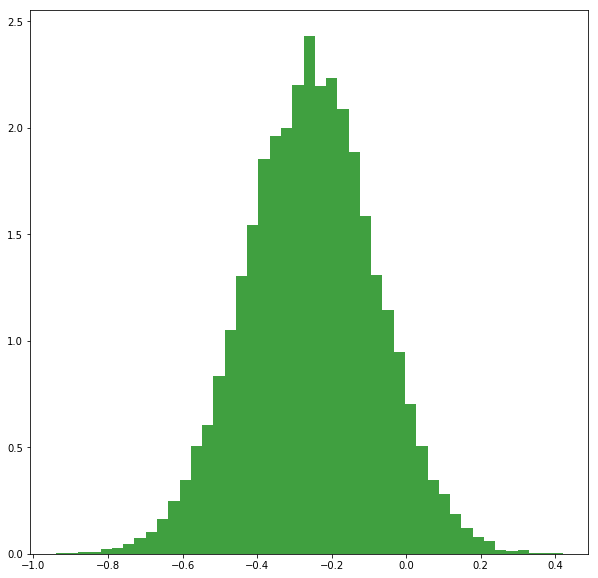

In [8]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X[:,0].reshape(-1,1), 45, density=True, facecolor='g', alpha=0.75)
plt.show()

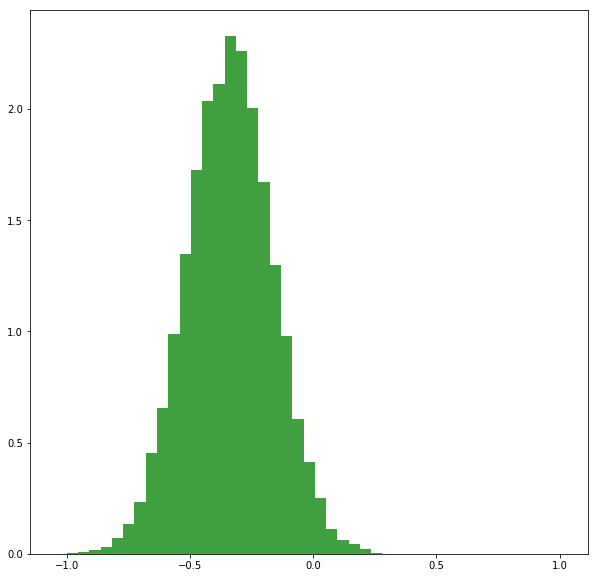

In [9]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X[:,1].reshape(-1,1), 45, density=True, facecolor='g', alpha=0.75)
plt.show()

### Ordinary weighted estimator with $$f(x_1, x_2) = x_1 + x_2$$

In [10]:
def local_weighted_estimator(X):
    return (X[:,0] + X[:,1]).mean()

In [11]:
print ("Weighted estimator = ",local_weighted_estimator(X))

Weighted estimator =  -0.5937776305116821


### Generation of N_train independent paths

In [12]:
def generate_lmc_from_initial(x_initial,Sigma,N):
    h = 0.01
    vkh = np.empty((N,d,1))
    ksi = np.random.randn(N,d,1)
    vkh[0] = x_initial
    for i in range(1,N):
        grad = f_grad(vkh[i-1], X_reg,Y_reg,Sigma)
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh, ksi

def generate_paths(x_initial,N_train,Sigma,N):
    XX = []
    ZZ = []
    for i in range(N_train):
        X, Z = generate_lmc_from_initial(x_initial[-i],Sigma,N)
        XX.append(X)
        ZZ.append(Z)
    return np.array(XX),np.array(ZZ)

In [13]:
np.random.seed(123)
XX, ZZ = generate_paths(X,100,Sigma,1000)

### (normalized) Hermite polynomials

In [157]:
def generate_k_vec(d, K):
    r = list(range(K+1))
    k = []
    for roll in product(r, repeat = d):
        k.append(list(roll))
    k.remove([0,0])
#     k.remove([1,3])
#     k.remove([2,3])
#     k.remove([2,2])
#     k.remove([3,2])
#     k.remove([3,1])
#     k.remove([3,3])

    k.remove([2,2])
    k.remove([2,1])
    k.remove([1,2])
    return k
def H(k, x):
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

In [158]:
k_comb = generate_k_vec(d,2)
k_comb

[[0, 1], [0, 2], [1, 0], [1, 1], [2, 0]]

### Fitting linear regression for $Q_{p,l}(x) = \mathbb{E} \left[f(X_p) | X_l = x\right]$

In [170]:
deg_pol = 6
def pol_ar_1d(x): #x.shape = (2,1)
    return np.array([1,x[0],x[1],x[0]*x[1],x[0]**2,x[1]**2])#,x[0]**2 *x[1],x[0]* x[1]**2, x[0]**3, x[1]**3])

def generate_X(XX, l):
    N_train = XX.shape[0]
    N = XX.shape[1]
    d = XX.shape[2]
    X = np.empty((N_train, deg_pol))
    X[:,0] = np.ones(N_train)
    X[:,1] = XX[:,l,0].squeeze()
    X[:,2] = XX[:,l,1].squeeze()
    X[:,3] = (XX[:,l,0] * XX[:,l,1]).squeeze()
    X[:,4] = (XX[:,l,0]**2).squeeze()
    X[:,5] = (XX[:,l,1]**2).squeeze()
#     X[:,6] = (XX[:,l,0]**2 * XX[:,l,1]).squeeze()
#     X[:,7] = (XX[:,l,0] * XX[:,l,1]**2).squeeze()
#     X[:,8] = (XX[:,l,0]**3).squeeze()
#     X[:,9] = (XX[:,l,1]**3).squeeze()
    return X 



def generate_y(XX,ZZ,l,n_tilde = 10):
    N_train = XX.shape[0]
    N = XX.shape[1]
    d = XX.shape[2]
    y = np.zeros(N_train)
    for s in range(N_train):
        y[s] = XX[s][l:l+n_tilde].sum()
    return y

def q_l_fit(XX,ZZ):
    N_train = XX.shape[0]
    N = XX.shape[1]
    d = XX.shape[2]
    Betas = np.zeros((N,deg_pol))
    for l in tqdm(range (N)):
        X = generate_X(XX,l)
        y = generate_y(XX,ZZ,l)
        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[l] = beta
    return Betas

def q_l_predict(x,l, Betas,k):
    x_pol = pol_ar_1d(x)
    beta = Betas[l]
    return (x_pol @ beta)

In [171]:
Betas = q_l_fit(XX,ZZ)

100%|██████████| 1000/1000 [00:00<00:00, 2265.22it/s]


In [172]:
# np.save('BLR_XX.npy',XX)
# np.save('BLR_ZZ.npy',ZZ)
# np.save('BLR_Betas.npy',Betas)

In [174]:
# Betas = np.load('BLR_Betas.npy')
# XX = np.load('BLR_XX.npy')
# ZZ = np.load('BLR_ZZ.npy')

In [175]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

l = 1
# Make data.
X_plot = np.linspace(generate_X(XX,l)[:,1].min(), generate_X(XX,l)[:,1].max(),num = 50)
Y_plot = np.linspace(generate_X(XX,l)[:,2].min(), generate_X(XX,l)[:,2].max(),num = 50)
X_plot, Y_plot = np.meshgrid(X_plot, Y_plot)
Z_plot_real = X_plot + Y_plot

Z_plot = np.empty((X_plot.shape[0],X_plot.shape[0]))
for i in range(X_plot.shape[0]):
    XY_plot = np.hstack((X_plot[i].reshape(-1,1,1), Y_plot[i].reshape(-1,1,1)))
    for j in range(X_plot.shape[0]):
        Z_plot[i,j] = q_l_predict(XY_plot[j],l,Betas, 0)
        
predict_plot = go.Surface(x = X_plot, y = Y_plot,z=Z_plot)
real_scatter = go.Scatter3d(
    x=generate_X(XX,l)[:,1],
    y=generate_X(XX,l)[:,2],
    z=generate_y(XX,ZZ,l),
    mode='markers',
    marker=dict(
        size=5,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)       
        
data = [predict_plot, real_scatter]
# plotly.offline.plot(data, filename="surface_Q_l={}".format(l))
plotly.offline.plot(data)

'file:///home/ubuntu/Paper_Belomestny/VR-MCMC/BLR_2d_reduced/temp-plot.html'

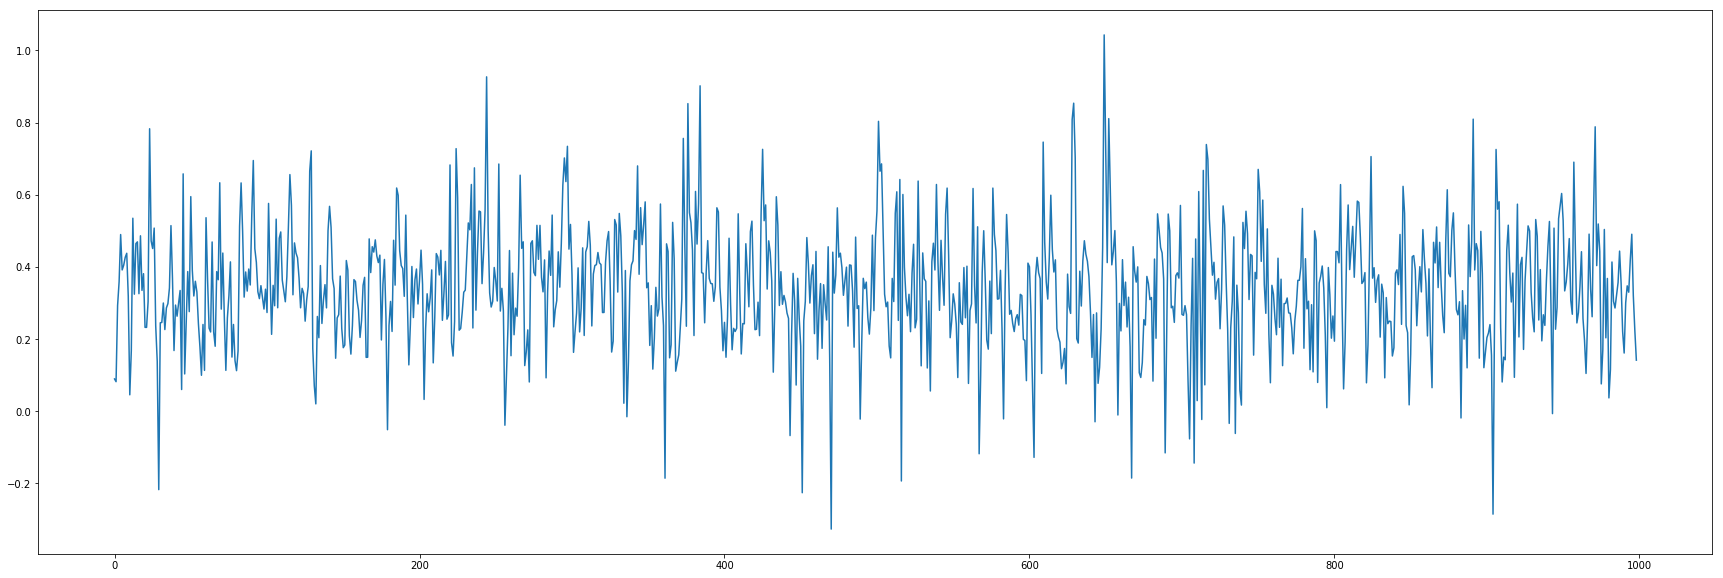

In [176]:
plot_a_lk = []
for i in range (1,XX.shape[1]):
    plot_a_lk.append(a_lk(XX[0],i,k_comb[0], Betas))
plot_a_lk = np.array(plot_a_lk)
plt.figure(figsize=(30,10))
plt.plot(plot_a_lk)

In [177]:
# degrees = np.array([[0,0],[1,0],[0,1],[1,1],[2,0],[0,2],[2,1],[1,2],[3,0],[0,3]])
# degrees = np.array([[0,0],[1,0],[0,1],[1,1]])
degrees = np.array([[0,0],[1,0],[0,1],[1,1],[2,0],[0,2]])

In [178]:
def a_lk(X,l,k_vec, Betas):
    d = 2
    h = 0.01
    S = 0
    x_hat = X[l-1] - h*f_grad(X[l-1],X_reg,Y_reg,Sigma)
    Small_s = np.zeros(d)
    for ind,deg in enumerate(degrees):
        Small_s[:] = 0
        for d, i in enumerate(deg):
            for t in range (i+1):
                for s in range (int(t/2 +1)):
                    if (k_vec[d] == t - 2*s):
                        Small_s[d] = Small_s[d] + comb(N=i, k = t, exact = True) * x_hat[0]**(i-t) * \
                        math.factorial(t)*1/math.factorial(s)*1 / np.sqrt(math.factorial(t-2*s)) *np.sqrt(2*h)**t /2**s
                    else:
                        pass
        S = S + Betas[l,ind] * Small_s.prod()
    return S

def M_bias(k_vec,X,Z, Betas):
    N = X.shape[0]
    S = 0
    for l in range (N):
        s = a_lk(X,l,k_vec, Betas)* Hermite_val(k_vec,Z[l])
        S = S + s
    return S/N

def estimator_bias(k,XX,ZZ,Betas,first, last):
    M_results = Parallel(n_jobs=-1)(delayed(M_bias)(k,XX[i],ZZ[i],Betas)for i in range(first, last))
    return np.array(M_results).reshape(-1)

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

In [179]:
X = XX[7]
Z = ZZ[7]
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X,Z,Betas),timeit.default_timer()-time_1))

P = -0.602861185496252
M ([0, 1]) = [-0.02458503] [Time:1.4463925979998749]
M ([0, 2]) = [0.00013263] [Time:2.9012323079987254]
M ([1, 0]) = [-0.00250978] [Time:4.362916235999364]
M ([1, 1]) = [0.00046066] [Time:5.72933102099887]
M ([2, 0]) = [-0.00156848] [Time:7.191009387999657]


In [180]:
X = XX[8]
Z = ZZ[8]
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X,Z,Betas),timeit.default_timer()-time_1))

P = -0.5857656313633813
M ([0, 1]) = [0.01027887] [Time:1.4893011410003965]
M ([0, 2]) = [-0.00195549] [Time:2.965344833999552]
M ([1, 0]) = [0.00212264] [Time:4.38605546799954]
M ([1, 1]) = [0.00110883] [Time:5.743235629999617]
M ([2, 0]) = [-0.00208152] [Time:7.189753062000818]


### Check on test

In [181]:
# np.random.seed(9651)
# X, Z = lmc_regression_without_precond(X_reg,Y_reg,Sigma, 10000)

# XX_test, ZZ_test =  generate_paths(X,100,Sigma,1000)

# P_test = estimator(XX_test)

# # np.save('BLR_XX_test', XX_test)
# # np.save('BLR_ZZ_test', ZZ_test)

In [182]:
# XX_test = np.load('BLR_XX_test.npy')
# ZZ_test = np.load('BLR_ZZ_test.npy')
# P_test = estimator(XX_test)

In [183]:
len(k_comb)

5

In [184]:
M_results = np.empty((len(k_comb), XX_test.shape[0]))

for i,k in enumerate(k_comb):
    M_results[i] = estimator_bias(k,XX_test,ZZ_test,Betas, 0, 100)

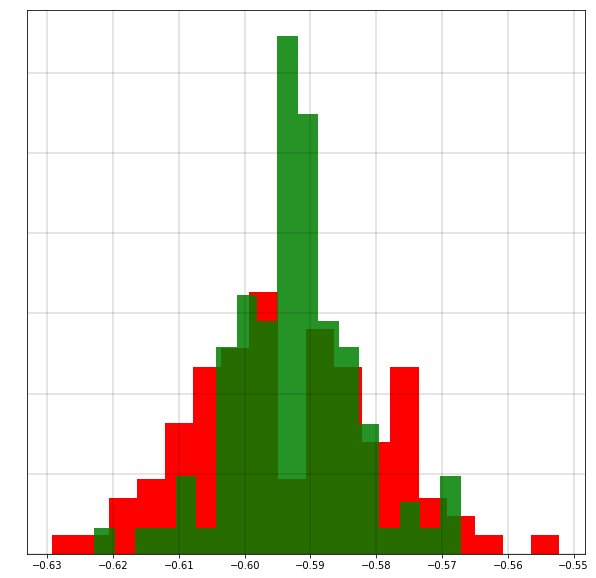

In [185]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(P_test.reshape(-1,1),18, facecolor='r', density=True,
                            alpha=1, label="Distribution of $\pi$")

n, bins, patches = plt.hist((P_test-M_results.sum(axis = 0)).reshape(-1,1), 18, density=True, facecolor='g', 
                            alpha=0.85, label="Distribution of $\pi - M^1_N$")

plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(
    axis='y',
    color = 'w',
    labelcolor = 'w',
    which='both')
# plt.xlim(-0.65, -0.53)
plt.show()

In [167]:
print ('Variance of Pi = ',P_test.var(ddof = 1))
print ('-----------------------------------------------------')
for i,k in enumerate(k_comb):
    print ('Variance of new estimator ({})= {}'.format(k_comb[i], (P_test - M_results[:i].sum(axis = 0)).var(ddof = 1)))
    print ("=====================================================")

Variance of Pi =  0.0002182263797588667
-----------------------------------------------------
Variance of new estimator ([0, 1])= 0.0002182263797588667
Variance of new estimator ([0, 2])= 0.00013684187755141967
Variance of new estimator ([1, 0])= 0.00013684187755141967
Variance of new estimator ([1, 1])= 6.051652024733879e-05
Variance of new estimator ([2, 0])= 6.153848161477935e-05


In [169]:
print (all_data[0].var(ddof = 1))
print (all_data[1].var(ddof = 1))
print (all_data[2].var(ddof = 1))

0.0002182263797588667
6.153848161477941e-05
6.153848161477935e-05


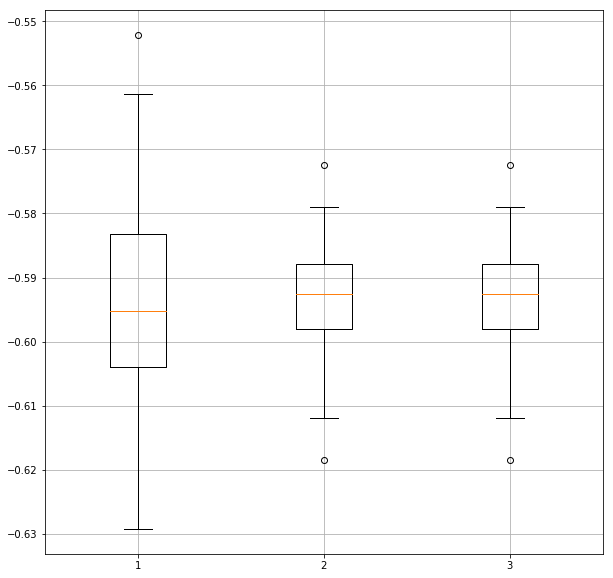

In [168]:
plt.figure(figsize=(10,10))

# generate some random test data
all_data = [P_test, P_test - M_results[0]-M_results[2]-M_results[3],
           P_test - M_results.sum(axis = 0)]

# plot violin plot
plt.boxplot(all_data)
# plt.title('')
plt.grid()
plt.show()

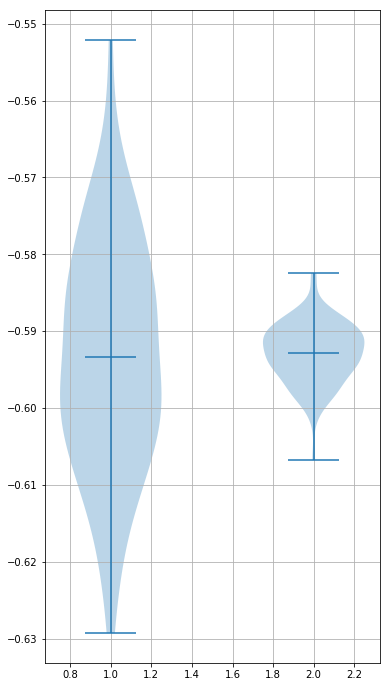

In [150]:
plt.figure(figsize=(6,12))
plt.violinplot(
        all_data, showmeans=True, showmedians=False)
# plt.title('violin plot')
plt.grid()
plt.show()